In [1]:
import numpy as np

class DATA():
    def __init__(self, matrix, label):
        self.matrix = matrix
        self.label = label   
        self.feature = None

In [2]:
def import_data(source, classified):
    if classified:
        digits_data = {}
    else:
        digits_data = []
        
    with open(source) as f:
        matrix = []
        vector = []
        for line in f:
            if len(line) > 10:
                for element in line.rstrip():  
                    vector.append(int(element))
                matrix.append(line.rstrip())
            else:
                class_idx = int(line.rstrip())
                observation = DATA(matrix, class_idx)
                observation.feature = np.array(vector)
                
                if classified:
                    if class_idx not in digits_data:
                        digits_data[class_idx] = [observation]
                    else:
                        digits_data[class_idx] = digits_data[class_idx] + [observation]
                    matrix = []
                    vector = []    
                else:
                    digits_data.append(observation)
                    matrix = []
                    vector = []
                    
    return digits_data

In [ ]:
def eval_prior(trn_data):
    prior = {}
    total = 0
    for i in range(10):
        total += len(trn_data[i])
    for i in range(10):
        prior[i] = len(trn_data[i]) / total
    return prior 

def likelihood(trn_data, target):
    feature_dict = {}
    for i in range(10):
        feature_dict[i] = np.zeros((32, 32))       
    for class_idx in range(10):
        digit_data = trn_data[class_idx]
        feature_prob = feature_dict[class_idx] 
        for i in range(32):
            for j in range(32): 
                f = 0
                num = 0
                for digit in digit_data:
                    if digit.matrix[i][j] == target:
                        f += 1
                    num += 1
                # Laplace Smoothing
                feature_prob[i][j] = (f+1)/(num+1)
                
    return feature_dict

def prediction(tst_data, prior, feature_dict_0, feature_dict_1):
    pred_label = {}
    for idx in range(10):
        digits_data = tst_data[idx]
        label = []
        for digit in digits_data:
            prob = np.zeros((10,))
            for class_idx in range(10):
                feature_class_1 = feature_dict_1[class_idx]
                feature_class_0 = feature_dict_0[class_idx]
                log_sum = np.log(prior[class_idx])
                for i in range(32):
                    for j in range(32):
                        if digit.matrix[i][j] == "0":
                            log_sum += np.log(feature_class_0[i][j])
                        else:
                            log_sum += np.log(feature_class_1[i][j])

                prob[class_idx] = log_sum
                
            label.append(int(np.argmax(prob)))
        pred_label[idx] = label
    return pred_label

def cor_rate(actual, predict):
    sum = 0
    for value in predict:
        if value == actual:
            sum += 1
    return sum / len(predict)

def correct_rate(pred_label):
    rate = np.zeros((10,))
    for i in range(10):
        rate[i] = cor_rate(i, pred_label[i])
    return rate

def correct_rate_overall(pred_label):
    hit = 0
    total = 0
    for i in range(10):
        for label in pred_label[i]:
            if label == i:
                hit += 1
            total += 1
    return hit / total

In [ ]:
trn_data = import_data("optdigits-orig_train.txt", True)
tst_data = import_data("optdigits-orig_test.txt", True)
prior = eval_prior(trn_data)

## Part 1.1: _Naive Bayes Classifier:_

In [ ]:
feature_dict_0 = likelihood(trn_data, "0")
feature_dict_1 = likelihood(trn_data, "1")
pred_label = prediction(tst_data, prior, feature_dict_0, feature_dict_1)

correct_rate(pred_label)

## Part 2.1: _Perceptron:_

Apply the multi-class (non-differentiable) perceptron learning rule from lecture to the digit classification problem from Part 1.1. As before, the basic feature set consists of a single binary indicator feature for each pixel. Specifically, the feature $F_{i,j}$ indicates the status of the (i,j)-th pixel. Its value is 1 if the pixel contains value 1, and 0 if it is 0. The images are of size 32*32, so there are 1024 features in total. For a multi-class perceptron, you need to learn a weight vector for each digit class. Each component of a weight vector corresponds to the weight of a pixel, which makes it of length either 1024 (without bias) or 1025 (with bias).

To get your results, you should tune the following parameters (it is not necessary to separately report results for multiple settings, only report which options you tried and which one worked the best):

- Learning rate decay function;
- Bias vs. no bias;
- Initialization of weights (zeros vs. random);
- Ordering of training examples (fixed vs. random);
- Number of epochs.

In [18]:
from random import randint
import random
%matplotlib inline
import matplotlib.pyplot as plt

def prediction_p(tst_data, w):
    pred = {}
    for class_idx in range(10):
        tst_data_i = tst_data[class_idx]
        label = []
        for data in tst_data_i:
            c = np.zeros((10,))
            for i in range(10):
                c[i] = data.feature @ w[i]
            label.append(int(np.argmax(c)))
        pred[class_idx] = label 
        
    return pred

def rate_helper(actual, predict):
    sum = 0
    for value in predict:
        if value == actual:
            sum += 1
    return sum / len(predict)

def correct_rate(pred_label):
    rate = np.zeros((10,))
    for i in range(10):
        rate[i] = rate_helper(i, pred_label[i])
    return rate

def correct_rate_overall(pred_label):
    hit = 0
    total = 0
    for i in range(10):
        for label in pred_label[i]:
            if label == i:
                hit += 1
            total += 1
    return hit / total

# This is a 10x10 matrix whose entry in row r and column c is 
# the percentage of test images from class r that are classified as class c
def confusion_matrix(pred_label):
    confusion = np.zeros((10, 10))
    for r in range(10):
        class_r = pred_label[r]
        num_cor = np.zeros((10,))
        total = 0
        for label in class_r:
            num_cor[label] += 1
            total += 1
        confusion[r] = num_cor / total
    return confusion

In [4]:
# Import overall training data
trn_data_unclassified = import_data("optdigits-orig_train.txt", classified = False)
trn_data = import_data("optdigits-orig_train.txt", classified = True)
tst_data = import_data("optdigits-orig_test.txt", classified = True)

- _**Implementing the Perceptron:**_

In [40]:
def perceptron(trn_data_unclassified, trn_data, epochs, bias, random_ordering, w):
    results = {}
    # Start:
    for n in range(epochs):
        train_data = trn_data_unclassified[:]
        if random_ordering:
            random.shuffle(train_data)

        for idx, digit in enumerate(train_data):
            eta = 1 / (0.01 * idx + 1) # Learning rate decay function

            for class_idx in range(10):
                if digit.label == class_idx:
                    y = 1
                else:
                    y = -1
                if (digit.feature @ w[class_idx] + bias) * y <= 0:
                    w[class_idx] = w[class_idx] + eta * y * digit.feature

        pred = prediction_p(trn_data, w)
        rate_overall = correct_rate_overall(pred)
        results[n+1] = rate_overall
        if rate_overall == 1:
            return results

    return results
    

- _**Setting the Tuning Parameters and start learning**_:

Overall Test Accuracy: 0.9504504504504504

Confusion Matrix:
[[1.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.9778 0.     0.     0.     0.     0.     0.0222 0.     0.    ]
 [0.     0.     0.8537 0.     0.     0.     0.     0.     0.122  0.0244]
 [0.     0.     0.     0.9697 0.     0.     0.     0.     0.     0.0303]
 [0.     0.0339 0.     0.     0.9153 0.     0.     0.     0.0339 0.0169]
 [0.     0.     0.     0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0233 0.     0.9535 0.     0.0233 0.    ]
 [0.     0.     0.     0.     0.0213 0.     0.     0.9787 0.     0.    ]
 [0.     0.     0.     0.     0.     0.025  0.     0.     0.975  0.    ]
 [0.0238 0.     0.0238 0.     0.     0.0238 0.     0.0238 0.0238 0.881 ]]


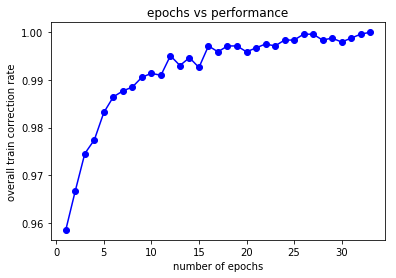

In [42]:
#w = np.zeros((10, 1024))
w = np.random.rand(10, 1024)
epochs = 50
bias = 0
random_ordering = True

#########################################################################################

results = perceptron(trn_data_unclassified, trn_data, epochs, bias, random_ordering, w)
pred = prediction_p(tst_data, w)
rate_overall = correct_rate_overall(pred)
confusion = confusion_matrix(pred)

#########################################################################################

print("Overall Test Accuracy: {}\n".format(rate_overall))
print("Confusion Matrix:")
np.set_printoptions(precision=4)
print(confusion)

n_epochs = list(results.keys())
trn_correct_rate = list(results.values())
plt.xlabel('number of epochs')
plt.ylabel('overall train correction rate')
plt.title('epochs vs performance')
plt.plot(n_epochs, trn_correct_rate, 'bo-')
plt.show()

- _**Discussion:**_

    - From the above code, it seems that when the ordering is random, bias doesn't really matter. Here we set bias = 0.
    - The decay training function is: $\eta = \frac{1}{0.001 * n + 1}$ with nth sample and decay rate 0.001.